# Daily VPD for one month prior to fire and 4-8 weeks

In [102]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rioxarray as rxr
import xarray as xr
from pykrige.ok import OrdinaryKriging
from shapely.geometry import box
import os
from tqdm import tqdm
import warnings
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns

Read in data

In [ ]:
daily_weather = pd.read_csv('../data/ont_shield_weather_station_1990_2021_vpd.csv')
nbac = gpd.read_file('../data/nbac_shield_natural_gt50_mostly_forested_2011_2021.geojson')

Check Columns

In [101]:
daily_weather.head()

,Unnamed: 0,station_id,long,lat,yr,mon,day,temp,rh,ws,prec,date,year,month,es,ea,vpd
0,1,1AL,-79.8746,44.1506,2000,4,18,6.0,81,15.0,0.0,2000-04-18,2000,4,0.935109,0.757439,0.177671
1,2,1AL,-79.8746,44.1506,2000,4,19,9.0,87,7.0,0.0,2000-04-19,2000,4,1.148060,0.998813,0.149248
2,3,1AL,-79.8746,44.1506,2000,4,23,12.0,62,13.0,0.0,2000-04-23,2000,4,1.402564,0.869590,0.532974
3,4,1AL,-79.8746,44.1506,2000,4,24,10.0,43,11.0,0.0,2000-04-24,2000,4,1.227963,0.528024,0.699939
4,5,1AL,-79.8746,44.1506,2000,4,25,10.0,27,8.0,0.0,2000-04-25,2000,4,1.227963,0.331550,0.896413


In [ ]:
nbac.columns
nbac.head()


Inspect daily_weather

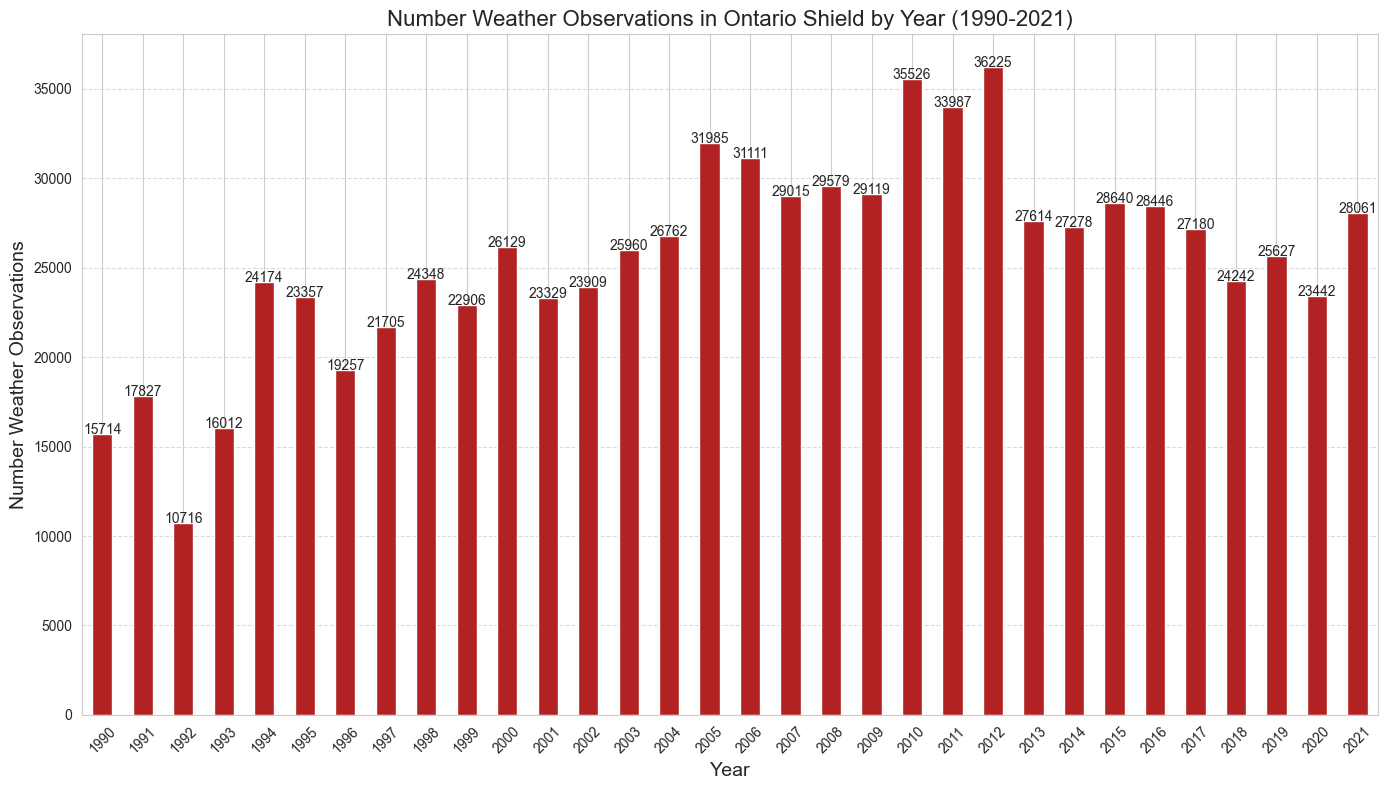

Total number of observations: 819182
Year with most observations: 2012 (36225 fires)
Year with fewest observations: 1992 (10716 fires)
Average observation per year: 25599.4


In [103]:

# Set the style for the plots
sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))

# Count fires by year
observations_per_year = daily_weather['year'].value_counts().sort_index()

# Create the bar chart
ax = observations_per_year.plot(kind='bar', color='firebrick')

# Add labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number Weather Observations', fontsize=14)
plt.title('Number Weather Observations in Ontario Shield by Year (1990-2021)', fontsize=16)

# Add data labels on top of each bar
for i, v in enumerate(observations_per_year):
    ax.text(i, v + 1, str(v), ha='center', fontsize=10)

# Improve x-axis labels
plt.xticks(rotation=45)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tight layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()

# Print summary statistics
print(f"Total number of observations: {len(daily_weather)}")
print(f"Year with most observations: {observations_per_year.idxmax()} ({observations_per_year.max()} fires)")
print(f"Year with fewest observations: {observations_per_year.idxmin()} ({observations_per_year.min()} fires)")
print(f"Average observation per year: {observations_per_year.mean():.1f}")

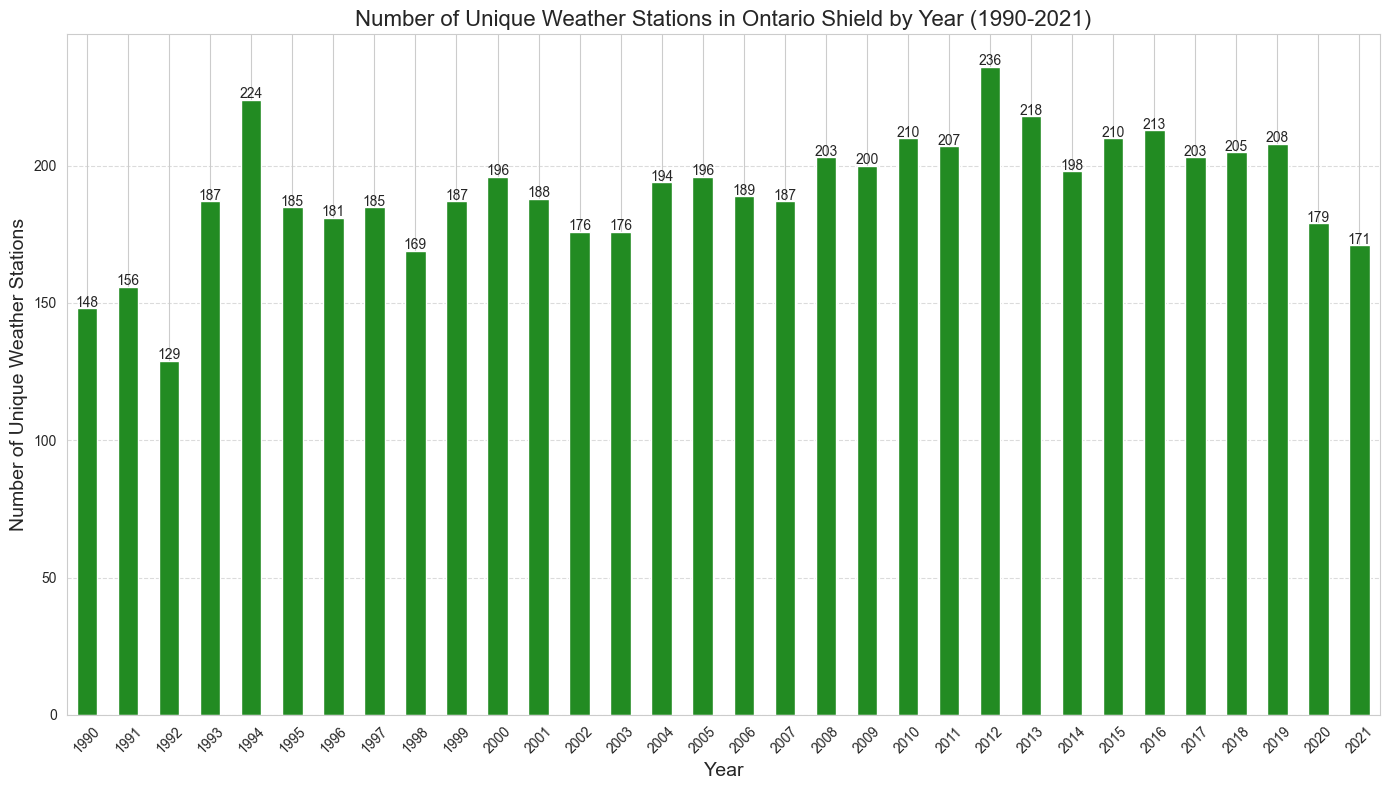

Total unique stations across all years: 547
Year with most stations: 2012 (236 stations)
Year with fewest stations: 1992 (129 stations)
Average stations per year: 191.1


In [104]:
# Set the style for the plots
sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))

# Count unique stations per year
stations_per_year = daily_weather.groupby('year')['station_id'].nunique()

# Create the bar chart
ax = stations_per_year.plot(kind='bar', color='forestgreen')

# Add labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Unique Weather Stations', fontsize=14)
plt.title('Number of Unique Weather Stations in Ontario Shield by Year (1990-2021)', fontsize=16)

# Add data labels on top of each bar
for i, v in enumerate(stations_per_year):
    ax.text(i, v + 0.5, str(v), ha='center', fontsize=10)

# Improve x-axis labels
plt.xticks(rotation=45)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tight layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()

# Print summary statistics
print(f"Total unique stations across all years: {daily_weather['station_id'].nunique()}")
print(f"Year with most stations: {stations_per_year.idxmax()} ({stations_per_year.max()} stations)")
print(f"Year with fewest stations: {stations_per_year.idxmin()} ({stations_per_year.min()} stations)")
print(f"Average stations per year: {stations_per_year.mean():.1f}")

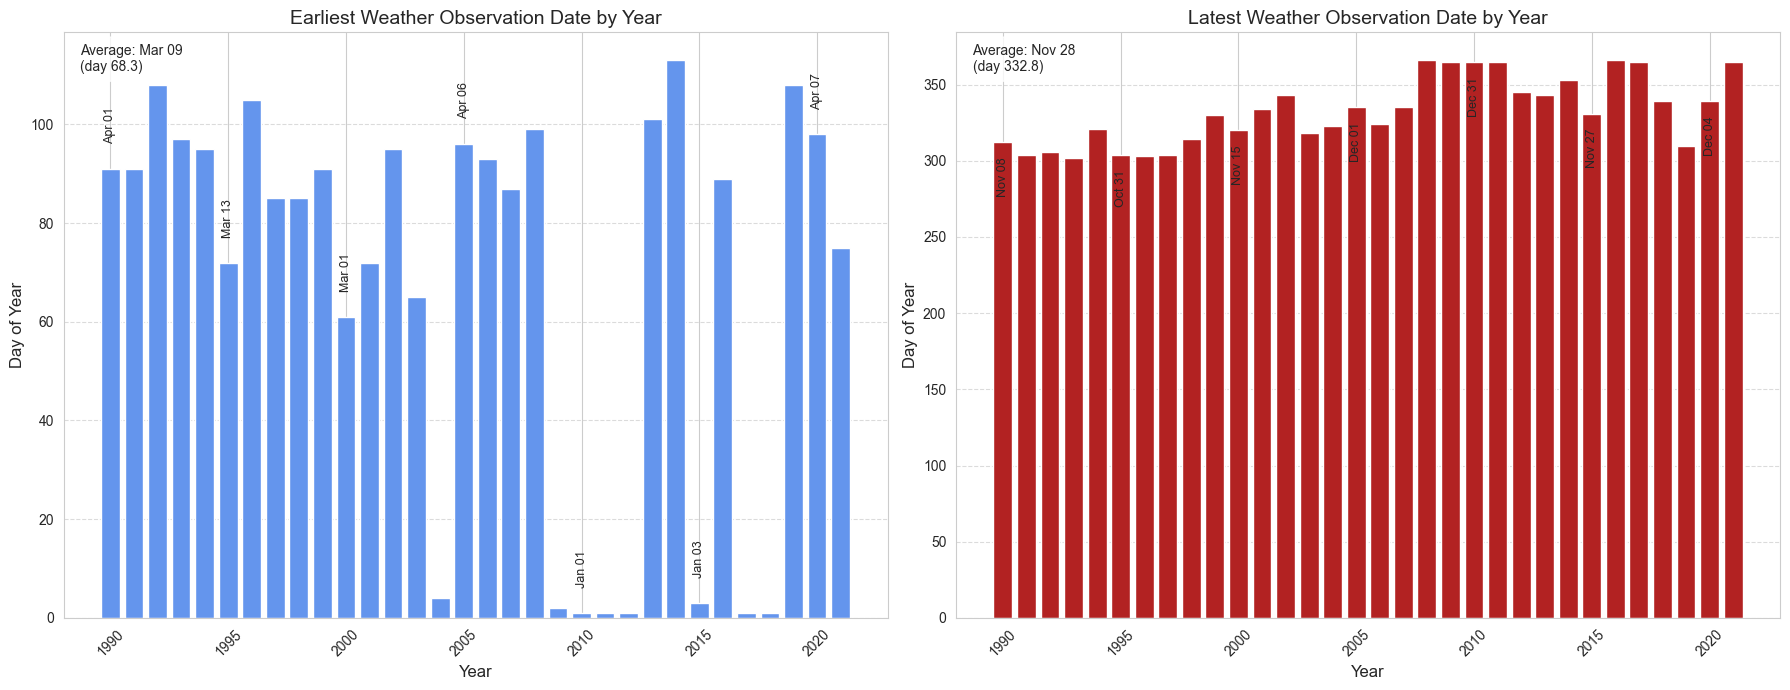

Earliest observation month distribution:
January: 8 years
March: 9 years
April: 15 years

Latest observation month distribution:
October: 5 years
November: 12 years
December: 15 years

Average earliest observation date: March 09 (day 68.3)
Average latest observation date: November 28 (day 332.8)


In [106]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Convert 'date' to datetime if it's not already
daily_weather['date'] = pd.to_datetime(daily_weather['date'])

# Extract month and day for analysis
daily_weather['month'] = daily_weather['date'].dt.month
daily_weather['day'] = daily_weather['date'].dt.day
daily_weather['doy'] = daily_weather['date'].dt.dayofyear  # Day of year

# Group by year and calculate earliest and latest observation date
earliest_dates = daily_weather.groupby('year')['date'].min().reset_index()
latest_dates = daily_weather.groupby('year')['date'].max().reset_index()

# Convert to day of year for easier plotting
earliest_dates['doy'] = earliest_dates['date'].dt.dayofyear
latest_dates['doy'] = latest_dates['date'].dt.dayofyear

# Create a month-day format for labels
earliest_dates['month_day'] = earliest_dates['date'].dt.strftime('%b %d')
latest_dates['month_day'] = latest_dates['date'].dt.strftime('%b %d')

# Calculate average earliest and latest dates for stats
avg_earliest_doy = earliest_dates['doy'].mean()
avg_latest_doy = latest_dates['doy'].mean()

avg_earliest_date = pd.to_datetime(f"2023-01-01") + pd.Timedelta(days=avg_earliest_doy-1)
avg_latest_date = pd.to_datetime(f"2023-01-01") + pd.Timedelta(days=avg_latest_doy-1)

# Plot earliest dates
ax1.bar(earliest_dates['year'], earliest_dates['doy'], color='cornflowerblue')
ax1.set_title('Earliest Weather Observation Date by Year', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Day of Year', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', rotation=45)

# Add month-day labels to some bars
for i, (year, row) in enumerate(earliest_dates.iterrows()):
    if i % 5 == 0:  # Label every 5th bar to avoid clutter
        ax1.text(row['year'], row['doy'] + 5, row['month_day'], 
                ha='center', va='bottom', rotation=90, fontsize=9)

# Add statistics to the top left corner of first plot
stats_text = (f"Average: {avg_earliest_date.strftime('%b %d')}\n"
              f"(day {avg_earliest_doy:.1f})")
ax1.text(0.02, 0.98, stats_text, 
        transform=ax1.transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

# Plot latest dates
ax2.bar(latest_dates['year'], latest_dates['doy'], color='firebrick')
ax2.set_title('Latest Weather Observation Date by Year', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Day of Year', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.tick_params(axis='x', rotation=45)

# Add month-day labels to some bars
for i, (year, row) in enumerate(latest_dates.iterrows()):
    if i % 5 == 0:  # Label every 5th bar to avoid clutter
        ax2.text(row['year'], row['doy'] - 10, row['month_day'], 
                ha='center', va='top', rotation=90, fontsize=9)

# Add statistics to the top left corner of second plot
stats_text = (f"Average: {avg_latest_date.strftime('%b %d')}\n"
              f"(day {avg_latest_doy:.1f})")
ax2.text(0.02, 0.98, stats_text, 
        transform=ax2.transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

# Adjust layout
plt.tight_layout()
plt.show()

# Print summary statistics (you can keep these for reference)
earliest_month_counts = earliest_dates['date'].dt.month.value_counts().sort_index()
latest_month_counts = latest_dates['date'].dt.month.value_counts().sort_index()

print("Earliest observation month distribution:")
for month, count in earliest_month_counts.items():
    month_name = pd.to_datetime(f"2023-{month}-01").strftime('%B')
    print(f"{month_name}: {count} years")

print("\nLatest observation month distribution:")
for month, count in latest_month_counts.items():
    month_name = pd.to_datetime(f"2023-{month}-01").strftime('%B')
    print(f"{month_name}: {count} years")

print(f"\nAverage earliest observation date: {avg_earliest_date.strftime('%B %d')} (day {avg_earliest_doy:.1f})")
print(f"Average latest observation date: {avg_latest_date.strftime('%B %d')} (day {avg_latest_doy:.1f})")

## 1. Daily for 1-month

- Get daily weather
- Get fire perimeters
- interpolate daily values for each day for the month before a fire
    1. for each fire, filter daily weather for the month prior to fire + 1 day for interpolating starting values ( Jain et al. 2017)
    2. for each day interpolate to 30x30m grid, do not save grid into memory
    3. Calculate the average across the interpolated grid for each day
    4. return csv for each fire for the days

Filter out fires where FIRECAUS is not 'Natural'


In [40]:
nbac_nat = nbac[nbac['FIRECAUS'] == "Natural"]
nbac_nat = nbac_nat[nbac_nat['YEAR'] >= 1990]

Clean the dates to get MONTH and DAY column

In [43]:
# First convert AFSDATE to datetime for proper date manipulation
nbac_nat['AG_SDATE'] = pd.to_datetime(nbac_nat['AG_SDATE'], errors='coerce')

# Extract month from AFSDATE
nbac_nat['FIRE_MONTH'] = nbac_nat['AG_SDATE'].dt.month

# Extract day of year (DOY) from AFSDATE
nbac_nat['FIRE_DOY'] = nbac_nat['AG_SDATE'].dt.dayofyear

# Check the first few rows to confirm the extraction worked
print(nbac_nat[['NFIREID', 'AG_SDATE', 'FIRE_MONTH', 'FIRE_DOY']].head())


   NFIREID                   AG_SDATE  FIRE_MONTH  FIRE_DOY
0     1084 1970-01-01 00:25:31.897200           1         1
1     2048 1970-01-01 00:25:31.897200           1         1
2      682 1970-01-01 00:19:17.698800           1         1
3      407 1970-01-01 00:20:45.135600           1         1
4      367 1970-01-01 00:20:45.135600           1         1


In [45]:
# Count fires by month to see the distribution
monthly_fires = nbac.groupby('FIRE_MONTH').size()
print("\nNumber of fires by month:")
print(monthly_fires)

# Check if there are any rows with missing date information
missing_dates = nbac[nbac['AG_SDATE'].isna()].shape[0]
print(f"\nNumber of fires with missing AFSDATE: {missing_dates}")


Number of fires by month:
FIRE_MONTH
5      80
6     538
7     515
8     131
9      55
10      1
dtype: int64

Number of fires with missing AFSDATE: 0


In [46]:
nbac_nat.head()

,ADJ_FLAG,ADJ_HA,ADMIN_AREA,AG_EDATE,AG_SDATE,AG_SDATE_YMD,BASRC,CAPDATE,FIRECAUS,FIREMAPM,...,HS_EDATE,HS_SDATE,NATPARK,NFIREID,POLY_HA,PRESCRIBED,VERSION,YEAR,geometry,FIRE_DOY
0,true,66.641922,ON,1534575600000,1970-01-01 00:25:31.897200,2018-07-18,Agency,NaN,Natural,Undefined,...,1.532156e+12,1.532156e+12,,1084,72.492568,,20240530,2018,"POLYGON ((-77.99445 46.20379, -77.99438 46.203...",1
1,true,586.834076,ON,1535094000000,1970-01-01 00:25:31.897200,2018-07-18,Agency,NaN,Natural,Undefined,...,1.532156e+12,1.532070e+12,,2048,696.593685,,20240530,2018,"POLYGON ((-78.09739 46.15034, -78.09726 46.149...",1
2,true,359.799436,ON,1160982000000,1970-01-01 00:19:17.698800,2006-09-08,Agency,NaN,Natural,Manually delineated,...,1.158304e+12,1.158217e+12,,682,418.791459,,20240530,2006,"POLYGON ((-88.92128 49.45669, -88.92125 49.456...",1
3,true,967.311582,ON,1248246000000,1970-01-01 00:20:45.135600,2009-06-16,Agency,NaN,Natural,Manually delineated,...,1.245308e+12,1.245222e+12,,407,1171.499040,,20240530,2009,"MULTIPOLYGON (((-87.55469 52.73397, -87.55471 ...",1
4,true,751.487347,ON,1248246000000,1970-01-01 00:20:45.135600,2009-06-16,Agency,NaN,Natural,Manually delineated,...,NaN,NaN,,367,900.941585,,20240530,2009,GEOMETRYCOLLECTION (LINESTRING (-88.12988 53.5...,1


Calculate reference dates

In [ ]:
def calculate_reference_dates(df):
    """
    Calculate reference dates for each fire:
    1. The day before the fire
    2. Exactly 4 weeks (28 days) before the fire
    
    Args:
        df: DataFrame or GeoDataFrame containing fire data with AG_SDATE_YMD column
        
    Returns:
        DataFrame with additional columns for reference dates
    """
    # Make a copy to avoid modifying the original
    result_df = df.copy()
    
    # Convert AG_SDATE_YMD to datetime if it's not already
    result_df['AG_SDATE_YMD'] = pd.to_datetime(result_df['AG_SDATE_YMD'])
    
    # Calculate the day before each fire
    result_df['DAY_BEFORE_FIRE'] = result_df['AG_SDATE_YMD'] - pd.Timedelta(days=1)
    
    # Calculate exactly 4 weeks (28 days) before the day before the fire
    result_df['FOUR_WEEKS_BEFORE_FIRE'] = result_df['AG_SDATE_YMD'] - pd.Timedelta(days=29)
    
    # Convert back to string format YYYY-MM-DD for easier use if needed
    result_df['DAY_BEFORE_FIRE_YMD'] = result_df['DAY_BEFORE_FIRE'].dt.strftime('%Y-%m-%d')
    result_df['FOUR_WEEKS_BEFORE_FIRE_YMD'] = result_df['FOUR_WEEKS_BEFORE_FIRE'].dt.strftime('%Y-%m-%d')
    
    return result_df

# Apply the function 
nbac_with_ref_dates = calculate_reference_dates(nbac_nat)

# Display the results
print(nbac_with_ref_dates[['NFIREID', 'AG_SDATE_YMD', 'DAY_BEFORE_FIRE_YMD', 'FOUR_WEEKS_BEFORE_FIRE_YMD']].head())

# Get the date range for each fire (from 4 weeks before to the day before)
nbac_with_ref_dates['DATE_RANGE_DAYS'] = (nbac_with_ref_dates['DAY_BEFORE_FIRE'] - 
                                          nbac_with_ref_dates['FOUR_WEEKS_BEFORE_FIRE']).dt.days

print(f"\nDate range for analysis: {nbac_with_ref_dates['DATE_RANGE_DAYS'].iloc[0]} days")

# Verify we have exactly 28 days difference 
nbac_with_ref_dates['DATE_RANGE_DAYS'].value_counts()

   NFIREID AG_SDATE_YMD DAY_BEFORE_FIRE_YMD FOUR_WEEKS_BEFORE_FIRE_YMD
0     1084   2018-07-18          2018-07-17                 2018-06-19
1     2048   2018-07-18          2018-07-17                 2018-06-19
2      682   2006-09-08          2006-09-07                 2006-08-10
3      407   2009-06-16          2009-06-15                 2009-05-18
4      367   2009-06-16          2009-06-15                 2009-05-18

Date range for analysis: 28 days


28    1125
Name: DATE_RANGE_DAYS, dtype: int64

In [50]:
nbac_with_ref_dates.head()

,ADJ_FLAG,ADJ_HA,ADMIN_AREA,AG_EDATE,AG_SDATE,AG_SDATE_YMD,BASRC,CAPDATE,FIRECAUS,FIREMAPM,...,PRESCRIBED,VERSION,YEAR,geometry,FIRE_DOY,DAY_BEFORE_FIRE,FOUR_WEEKS_BEFORE_FIRE,DAY_BEFORE_FIRE_YMD,FOUR_WEEKS_BEFORE_FIRE_YMD,DATE_RANGE_DAYS
0,true,66.641922,ON,1534575600000,1970-01-01 00:25:31.897200,2018-07-18,Agency,NaN,Natural,Undefined,...,,20240530,2018,"POLYGON ((-77.99445 46.20379, -77.99438 46.203...",1,2018-07-17,2018-06-19,2018-07-17,2018-06-19,28
1,true,586.834076,ON,1535094000000,1970-01-01 00:25:31.897200,2018-07-18,Agency,NaN,Natural,Undefined,...,,20240530,2018,"POLYGON ((-78.09739 46.15034, -78.09726 46.149...",1,2018-07-17,2018-06-19,2018-07-17,2018-06-19,28
2,true,359.799436,ON,1160982000000,1970-01-01 00:19:17.698800,2006-09-08,Agency,NaN,Natural,Manually delineated,...,,20240530,2006,"POLYGON ((-88.92128 49.45669, -88.92125 49.456...",1,2006-09-07,2006-08-10,2006-09-07,2006-08-10,28
3,true,967.311582,ON,1248246000000,1970-01-01 00:20:45.135600,2009-06-16,Agency,NaN,Natural,Manually delineated,...,,20240530,2009,"MULTIPOLYGON (((-87.55469 52.73397, -87.55471 ...",1,2009-06-15,2009-05-18,2009-06-15,2009-05-18,28
4,true,751.487347,ON,1248246000000,1970-01-01 00:20:45.135600,2009-06-16,Agency,NaN,Natural,Manually delineated,...,,20240530,2009,GEOMETRYCOLLECTION (LINESTRING (-88.12988 53.5...,1,2009-06-15,2009-05-18,2009-06-15,2009-05-18,28


Function to krige daily weather to fire perimeter

In [67]:
daily_weather.columns
daily_weather.head()

,Unnamed: 0,station_id,long,lat,yr,mon,day,temp,rh,ws,prec,date,year,month,es,ea,vpd
0,1,1AL,-79.8746,44.1506,2000,4,18,6.0,81,15.0,0.0,2000-04-18,2000,4,0.935109,0.757439,0.177671
1,2,1AL,-79.8746,44.1506,2000,4,19,9.0,87,7.0,0.0,2000-04-19,2000,4,1.148060,0.998813,0.149248
2,3,1AL,-79.8746,44.1506,2000,4,23,12.0,62,13.0,0.0,2000-04-23,2000,4,1.402564,0.869590,0.532974
3,4,1AL,-79.8746,44.1506,2000,4,24,10.0,43,11.0,0.0,2000-04-24,2000,4,1.227963,0.528024,0.699939
4,5,1AL,-79.8746,44.1506,2000,4,25,10.0,27,8.0,0.0,2000-04-25,2000,4,1.227963,0.331550,0.896413


In [80]:
# Example usage with corrected column names:
def interpolate_daily_weather_for_fires(fire_data, daily_weather, max_fires=None, output_dir='../data/interpolated_vpd'):
    """
    For each fire, filter daily weather data for the reference date period,
    create a 30x30m grid for the fire perimeter, and perform ordinary kriging
    for each day to get interpolated VPD values.
    
    Args:
        fire_data: GeoDataFrame with fire perimeters and reference dates
        daily_weather: DataFrame with daily weather station data (VPD)
        max_fires: Maximum number of fires to process (None for all)
        output_dir: Directory to save the output rasters
        
    Returns:
        Dictionary with NFIREID as keys and paths to saved rasters as values
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Check the actual column names in daily_weather
    print("Available columns in daily_weather:", daily_weather.columns.tolist())
    
    # Prepare the station coordinates - use the actual date column name from your data
    daily_weather['date'] = pd.to_datetime(daily_weather['date'])
    
    # Limit the number of fires if specified
    if max_fires is not None:
        fire_data = fire_data.iloc[:max_fires].copy()
        
    print(f"Processing {len(fire_data)} fires...")
    
    # Dictionary to store results
    results = {}
    
    # Process each fire
    for idx, fire in tqdm(fire_data.iterrows(), total=len(fire_data)):
        fire_id = fire['NFIREID']
        try:
            # Get fire geometry
            fire_geom = fire.geometry
            
            # Get the bounding box of the fire perimeter
            minx, miny, maxx, maxy = fire_geom.bounds
            
            # Add a buffer around the fire perimeter (500m)
            buffer = 500  # meters
            x_buffer = buffer
            y_buffer = buffer
            
            minx -= x_buffer
            miny -= y_buffer
            maxx += x_buffer
            maxy += y_buffer
            
            # Get the dates for this fire
            start_date = fire['FOUR_WEEKS_BEFORE_FIRE']
            end_date = fire['DAY_BEFORE_FIRE']
            
            # Get the date range for this fire
            date_range = pd.date_range(start=start_date, end=end_date, freq='D')
            
            # Filter weather data for this date range - use 'date' instead of 'DATE'
            fire_weather = daily_weather[
                (daily_weather['date'] >= start_date) & 
                (daily_weather['date'] <= end_date)
            ].copy()
            
            # Check if we have enough data for this fire
            if len(fire_weather) == 0:
                print(f"No weather data available for fire {fire_id} in date range {start_date} to {end_date}")
                continue
                
            # Create a 30x30m grid for the fire perimeter
            # Calculate number of cells in x and y directions
            x_res = 30  # meters
            y_res = 30  # meters
            
            nx = int((maxx - minx) / x_res) + 1
            ny = int((maxy - miny) / y_res) + 1
            
            # Create grid coordinates
            x_grid = np.linspace(minx, maxx, nx)
            y_grid = np.linspace(miny, maxy, ny)
            
            # Create empty array to store the interpolated values for each day
            # Dimensions: [time, y, x]
            data_array = np.zeros((len(date_range), ny, nx))
            data_array.fill(np.nan)
            
            # Perform ordinary kriging for each day
            for i, date in enumerate(date_range):
                # Filter weather data for this specific date - use 'date' instead of 'DATE'
                day_weather = fire_weather[fire_weather['date'] == date]
                
                # Skip if we don't have enough stations for this day (need at least 3 for kriging)
                if len(day_weather) < 3:
                    print(f"Not enough stations ({len(day_weather)}) for fire {fire_id} on {date.strftime('%Y-%m-%d')}")
                    continue
                
                # Get coordinates and VPD values for kriging - use correct column names
                x = day_weather['long'].values
                y = day_weather['lat'].values
                z = day_weather['vpd'].values
                
                # Skip if we have NaN values
                if np.isnan(z).any():
                    valid_indices = ~np.isnan(z)
                    x = x[valid_indices]
                    y = y[valid_indices]
                    z = z[valid_indices]
                    
                    # Still need at least 3 valid points
                    if len(z) < 3:
                        print(f"Not enough valid stations ({len(z)}) for fire {fire_id} on {date.strftime('%Y-%m-%d')}")
                        continue
                
                # Create the kriging model
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")  # Suppress convergence warnings
                    try:
                        OK = OrdinaryKriging(
                            x, y, z,
                            variogram_model='spherical',
                            verbose=False,
                            enable_plotting=False
                        )
                        
                        # Perform kriging on the grid
                        z_pred, ss = OK.execute('grid', x_grid, y_grid)
                        
                        # Store the interpolated values
                        data_array[i, :, :] = z_pred
                    except Exception as e:
                        print(f"Kriging failed for fire {fire_id} on {date.strftime('%Y-%m-%d')}: {str(e)}")
                        continue
            
            # Create the rioxarray object
            # First create an xarray DataArray
            coords = {
                'time': date_range,
                'y': y_grid,
                'x': x_grid
            }
            
            dims = ['time', 'y', 'x']
            
            # Create the DataArray
            da = xr.DataArray(
                data=data_array,
                dims=dims,
                coords=coords,
                attrs={
                    'long_name': 'Vapor Pressure Deficit',
                    'units': 'kPa',
                    'crs': 'EPSG:4326'  # Assuming WGS84
                }
            )
            
            # Convert to rioxarray
            rxda = da.rio.write_crs('EPSG:4326')
            
            # Set the spatial reference system
            rxda.rio.write_crs('EPSG:4326', inplace=True)
            
            # Clip to the fire perimeter
            # Convert fire geometry to GeoJSON format
            if hasattr(fire_geom, '__geo_interface__'):
                geojson = fire_geom.__geo_interface__
            else:
                # Handle the case where geometry is already a dict
                geojson = fire_geom
                
            # Clip the raster to the fire perimeter
            clipped = rxda.rio.clip([geojson], all_touched=True)
            
            # Save the result to a NetCDF file
            output_file = os.path.join(output_dir, f"{fire_id}_vpd.nc")
            # Create a dataset with an explicit variable name
            ds = xr.Dataset({"vpd": clipped})
            ds.to_netcdf(output_file)       
            
            
            # Store the paths in the results dictionary
            results[fire_id] = {
                'netcdf': output_file,
                'dates': date_range.strftime('%Y-%m-%d').tolist(),
                'num_days': len(date_range)
            }
            
            print(f"Successfully processed fire {fire_id} ({idx+1}/{len(fire_data)})")
            
        except Exception as e:
            print(f"Error processing fire {fire_id}: {str(e)}")
            
    print(f"Completed processing {len(results)}/{len(fire_data)} fires")
    return results


In [100]:
results = interpolate_daily_weather_for_fires(
    fire_data=nbac_with_ref_dates,
    daily_weather=daily_weather,
    max_fires=None,
    output_dir='../data/interpolated_daily_weather'
)




Available columns in daily_weather: ['Unnamed: 0', 'station_id', 'long', 'lat', 'yr', 'mon', 'day', 'temp', 'rh', 'ws', 'prec', 'date', 'year', 'month', 'es', 'ea', 'vpd']
Processing 1125 fires...


  0%|          | 0/1125 [00:00<?, ?it/s]

  0%|          | 1/1125 [00:10<3:14:56, 10.41s/it]

Successfully processed fire 1084 (1/1125)


  0%|          | 2/1125 [00:20<3:09:23, 10.12s/it]

Successfully processed fire 2048 (2/1125)


  0%|          | 3/1125 [00:30<3:11:40, 10.25s/it]

Successfully processed fire 682 (3/1125)


  0%|          | 4/1125 [00:40<3:09:56, 10.17s/it]

Successfully processed fire 407 (4/1125)


  0%|          | 5/1125 [00:51<3:12:57, 10.34s/it]

Error processing fire 367: [Errno 13] Permission denied: '/Users/jgoldman/Work/PhD/time-lagged-moisture-project/data/interpolated_daily_weather/367_vpd.nc'


  1%|          | 6/1125 [01:01<3:09:40, 10.17s/it]

Successfully processed fire 1240 (6/1125)


  1%|          | 7/1125 [01:11<3:09:03, 10.15s/it]

Successfully processed fire 1239 (7/1125)


  1%|          | 8/1125 [01:21<3:08:43, 10.14s/it]

Successfully processed fire 1217 (8/1125)


  1%|          | 9/1125 [01:31<3:06:53, 10.05s/it]

Successfully processed fire 472 (9/1125)


  1%|          | 10/1125 [01:41<3:06:01, 10.01s/it]

Successfully processed fire 600 (10/1125)


  1%|          | 11/1125 [01:51<3:05:38, 10.00s/it]

Successfully processed fire 522 (11/1125)


  1%|          | 12/1125 [02:01<3:05:14,  9.99s/it]

Successfully processed fire 598 (12/1125)


  1%|          | 12/1125 [02:05<3:13:21, 10.42s/it]


KeyboardInterrupt: 

Extract timeseries
- *error* due to .data being __xarrary_dataarray_variable__

In [ ]:
def extract_vpd_timeseries(fire_data, interpolated_dir='../data/interpolated_daily_weather', 
                           max_fires=None, plot=True, save_csv=True):
    """
    Extract time series of VPD values from the pixel nearest to each fire perimeter centroid.
    
    Args:
        fire_data: GeoDataFrame with fire perimeters and reference dates
        interpolated_dir: Directory containing the interpolated NetCDF files
        max_fires: Maximum number of fires to process (None for all)
        plot: Whether to plot the time series
        save_csv: Whether to save the time series to CSV
        
    Returns:
        Dictionary with NFIREID as keys and DataFrames of time series as values
    """
    import os
    import xarray as xr
    import pandas as pd
    import matplotlib.pyplot as plt
    from shapely.geometry import Point
    
    # Create output directory for CSV files
    if save_csv:
        csv_dir = os.path.join(os.path.dirname(interpolated_dir), 'vpd_timeseries')
        os.makedirs(csv_dir, exist_ok=True)
    
    # Create output directory for plots
    if plot:
        plot_dir = os.path.join(os.path.dirname(interpolated_dir), 'vpd_plots')
        os.makedirs(plot_dir, exist_ok=True)
    
    # Limit the number of fires if specified
    if max_fires is not None:
        fire_data = fire_data.iloc[:max_fires].copy()
    
    # Dictionary to store results
    results = {}
    
    # Process each fire
    for idx, fire in fire_data.iterrows():
        fire_id = fire['NFIREID']
        
        # Check if NetCDF file exists
        nc_file = os.path.join(interpolated_dir, f"{fire_id}_vpd.nc")
        if not os.path.exists(nc_file):
            print(f"NetCDF file for fire {fire_id} not found: {nc_file}")
            continue
        
        try:
            # Get the centroid of the fire perimeter
            centroid = fire.geometry.centroid
            
            # Open the NetCDF file
            ds = xr.open_dataset(nc_file)
            
            # Get the nearest pixel to the centroid
            # Convert the dataset to DataFrame for easier manipulation
            da = ds['data']  # Assuming the data variable is named 'data'
            
            # Get x,y coordinates of the centroid
            centroid_x, centroid_y = centroid.x, centroid.y
            
            # Find the nearest pixel to the centroid
            # Calculate distances to all grid points
            distances = ((da.x - centroid_x)**2 + (da.y - centroid_y)**2)**0.5
            
            # Get indices of the minimum distance
            min_idx = distances.argmin()
            min_y, min_x = np.unravel_index(min_idx.values, distances.shape)
            
            # Extract the time series at the nearest pixel
            timeseries = da.isel(y=min_y, x=min_x)
            
            # Convert to pandas DataFrame
            df = timeseries.to_dataframe(name='vpd').reset_index()
            
            # Format the date column
            df['date'] = df['time'].dt.strftime('%Y-%m-%d')
            
            # Keep only relevant columns
            df = df[['date', 'vpd']]
            
            # Add fire information
            df['NFIREID'] = fire_id
            df['FIRE_DATE'] = fire['AG_SDATE_YMD']
            df['DAYS_BEFORE_FIRE'] = (pd.to_datetime(fire['AG_SDATE_YMD']) - 
                                     pd.to_datetime(df['date'])).dt.days
            
            # Save to CSV if requested
            if save_csv:
                csv_file = os.path.join(csv_dir, f"{fire_id}_vpd_timeseries.csv")
                df.to_csv(csv_file, index=False)
                print(f"Saved time series for fire {fire_id} to {csv_file}")
            
            # Plot if requested
            if plot:
                plt.figure(figsize=(12, 6))
                plt.plot(df['date'], df['vpd'], marker='o')
                plt.axvline(x=fire['DAY_BEFORE_FIRE_YMD'], color='r', linestyle='--', 
                           label='Day before fire')
                plt.axvline(x=fire['FOUR_WEEKS_BEFORE_FIRE_YMD'], color='g', linestyle='--',
                           label='4 weeks before fire')
                plt.title(f"VPD Time Series for Fire {fire_id} ({fire['AG_SDATE_YMD']})")
                plt.xlabel('Date')
                plt.ylabel('VPD (kPa)')
                plt.xticks(rotation=45)
                plt.grid(True)
                plt.tight_layout()
                plt.legend()
                
                # Save plot
                plot_file = os.path.join(plot_dir, f"{fire_id}_vpd_timeseries.png")
                plt.savefig(plot_file, dpi=300)
                plt.close()
                print(f"Saved plot for fire {fire_id} to {plot_file}")
            
            # Store results
            results[fire_id] = df
            
            # Clean up
            ds.close()
            
        except Exception as e:
            print(f"Error processing time series for fire {fire_id}: {str(e)}")
    
    # Print summary
    print(f"\nExtracted time series for {len(results)} fires")
    
    return results





Error processing time series for fire 1084: 'data'
Error processing time series for fire 2048: 'data'
Error processing time series for fire 682: 'data'
Error processing time series for fire 407: 'data'
Error processing time series for fire 367: 'data'

Extracted time series for 0 fires


Extract results
*ERROR* data variables is not .data but __xarray_datarray_variable__

In [84]:
# Example usage
timeseries_results = extract_vpd_timeseries(
    fire_data=nbac_with_ref_dates,
    interpolated_dir='../data/interpolated_daily_weather',
    max_fires=1,  # Process the same fires as before
    plot=False,
    save_csv=False
)

Error processing time series for fire 1084: 'data'

Extracted time series for 0 fires


Look at a single vpd to find where data variables are contained

In [82]:
#read in .nc file
def read_vpd_netcdf(file_path):
    """
    Read a NetCDF file containing VPD data and return it as an xarray Dataset.
    
    Args:
        file_path: Path to the NetCDF file
    Returns:
        xarray Dataset containing the VPD data
    """         
    try:
        ds = xr.open_dataset(file_path)
        print(f"Successfully read NetCDF file: {file_path}")
        return ds
    except Exception as e:
        print(f"Error reading NetCDF file {file_path}: {str(e)}")
        return None
# Example usage
vpd_ds = read_vpd_netcdf('../data/interpolated_daily_weather/367_vpd.nc')

Successfully read NetCDF file: ../data/interpolated_daily_weather/367_vpd.nc


In [98]:
# name of the variable containing VPD data
list(vpd_ds.data_vars)[1]


'__xarray_dataarray_variable__'

Function to visualize the mean of all pixels in an image

In [95]:
def plot_fire_vpd_time_series(fire_id, interpolated_dir='../data/interpolated_daily_weather'):
    """
    Extract and plot the VPD time series for a specific fire.
    
    Args:
        fire_id: ID of the fire to plot
        interpolated_dir: Directory containing the interpolated NetCDF files
    """
    import xarray as xr
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Define the file path
    nc_file = os.path.join(interpolated_dir, f"{fire_id}_vpd.nc")
    
    # Check if the file exists
    if not os.path.exists(nc_file):
        print(f"NetCDF file for fire {fire_id} not found: {nc_file}")
        return
    
    try:
        # Open the NetCDF file
        ds = xr.open_dataset(nc_file)
        
        # Print the data variables to see what's available
        print(f"Data variables in the NetCDF file: {list(ds.data_vars)}")
        
        # Access the variable by name - using the name we found in your dataset
        if 'vpd' in ds:
            da = ds['vpd']
        elif '__xarray_dataarray_variable__' in ds:
            da = ds['__xarray_dataarray_variable__']
        else:
            # Use the first variable if neither is found
            var_name = list(ds.data_vars)[0]
            da = ds[var_name]
            print(f"Using variable '{var_name}'")
        
        # Calculate the mean VPD across the fire area for each time step
        vpd_mean = da.mean(dim=['x', 'y'])
        
        # Convert to a DataFrame for easier plotting
        df = vpd_mean.to_dataframe(name='mean_vpd')
        df = df.reset_index()
        
        # Format the date for better readability
        df['date_str'] = df['time'].dt.strftime('%Y-%m-%d')
        
        # Create the plot
        plt.figure(figsize=(12, 6))
        
        # Plot the mean VPD
        plt.plot(df['time'], df['mean_vpd'], marker='o', linestyle='-', linewidth=2)
        
        # Add labels and title
        plt.title(f"Mean VPD Time Series for Fire {fire_id}", fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('VPD (kPa)', fontsize=12)
        
        # Format x-axis dates
        plt.xticks(rotation=45)
        
        # Add grid
        plt.grid(True, alpha=0.3)
        
        # Tight layout
        plt.tight_layout()
        
        # Show the plot
        plt.show()
        
        # Return the dataframe for further analysis
        return df
        
    except Exception as e:
        print(f"Error processing fire {fire_id}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None



Data variables in the NetCDF file: ['spatial_ref', '__xarray_dataarray_variable__']


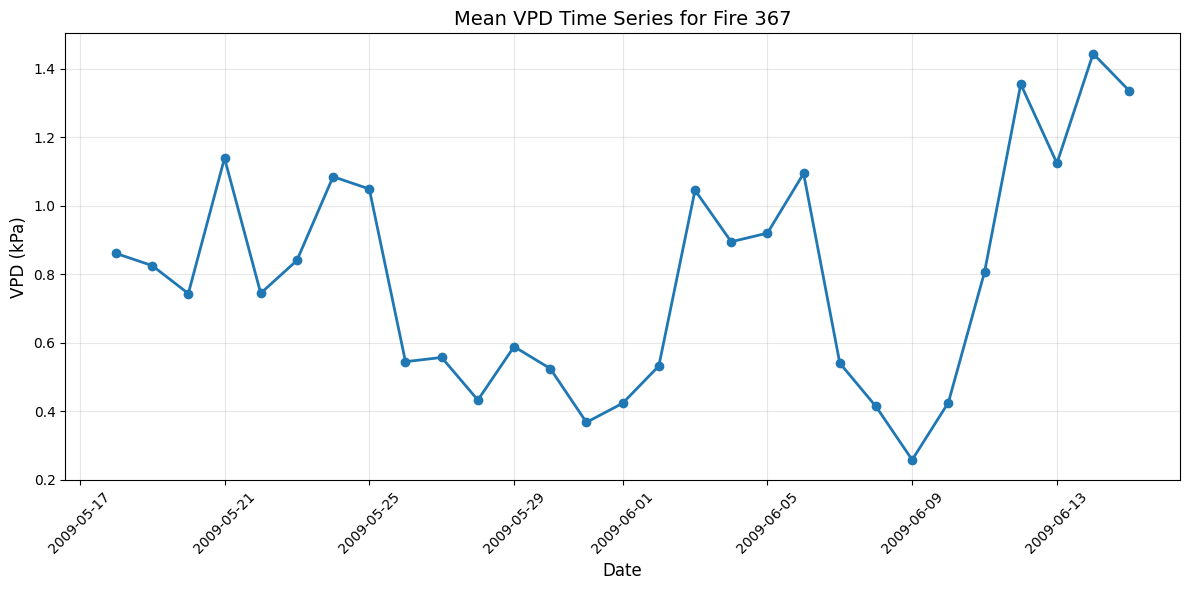


Mean VPD values:
     date_str  mean_vpd
0  2009-05-18  0.860835
1  2009-05-19  0.825162
2  2009-05-20  0.743514
3  2009-05-21  1.139149
4  2009-05-22  0.744231
5  2009-05-23  0.840223
6  2009-05-24  1.084947
7  2009-05-25  1.048974
8  2009-05-26  0.544395
9  2009-05-27  0.556745


In [96]:
# Example usage: plot the VPD time series for fire ID 367
fire_vpd_df = plot_fire_vpd_time_series(367)

# You can also print the dataframe to see the values
if fire_vpd_df is not None:
    print("\nMean VPD values:")
    print(fire_vpd_df[['date_str', 'mean_vpd']].head(10))